In [1]:
import pandas as pd
from dtaidistance.subsequence.dtw import subsequence_alignment
from dtaidistance import dtw_visualisation as dtwvis

In [2]:
from geoxts.data_processing_functions import *
from geoxts.benchmark_data import Well_grlog_cleaning, recall_tops, plot_result_distribution

### Training dataset

In [3]:
#We first create downsample the gamma rays to per feet.
df_log = pd.read_parquet('data/well_logs_data/Colorado_data/Training/logs.parquet', engine='fastparquet')
#df_log = df_log.set_index('wellName')
df_log.loc[df_log['GR'] < -1, 'GR' ] = -1
df_log.head()

,wellName,DEPTH,GR
1,512320698.0,421.0,96.9752
2,512320698.0,421.5,102.3324
3,512320698.0,422.0,104.6432
4,512320698.0,422.5,99.2187
5,512320698.0,423.0,92.0200


In [10]:
df_tops = pd.read_parquet('data/well_logs_data/Colorado_data/Training/tops.parquet', engine='fastparquet')
df_tops.set_index('well_name', inplace = True)
cols = ['NIOBARA','CODELL', 'FORT_HAYS']
df_tops = df_tops[cols]
df_tops.dropna(inplace = True)
df_tops.head()

,NIOBARA,CODELL,FORT_HAYS
well_name,,,
512320698.0,6398.0,6638.0,6661.0
512320699.0,6407.0,6656.0,6676.0
512320928.0,6520.0,6746.0,6793.0
512320970.0,6544.0,6770.0,6816.0
512320971.0,6510.0,6742.0,6789.0


Progress: 33.333333333333336 %
Progress: 66.66666666666667 %
Progress: 100.0 %


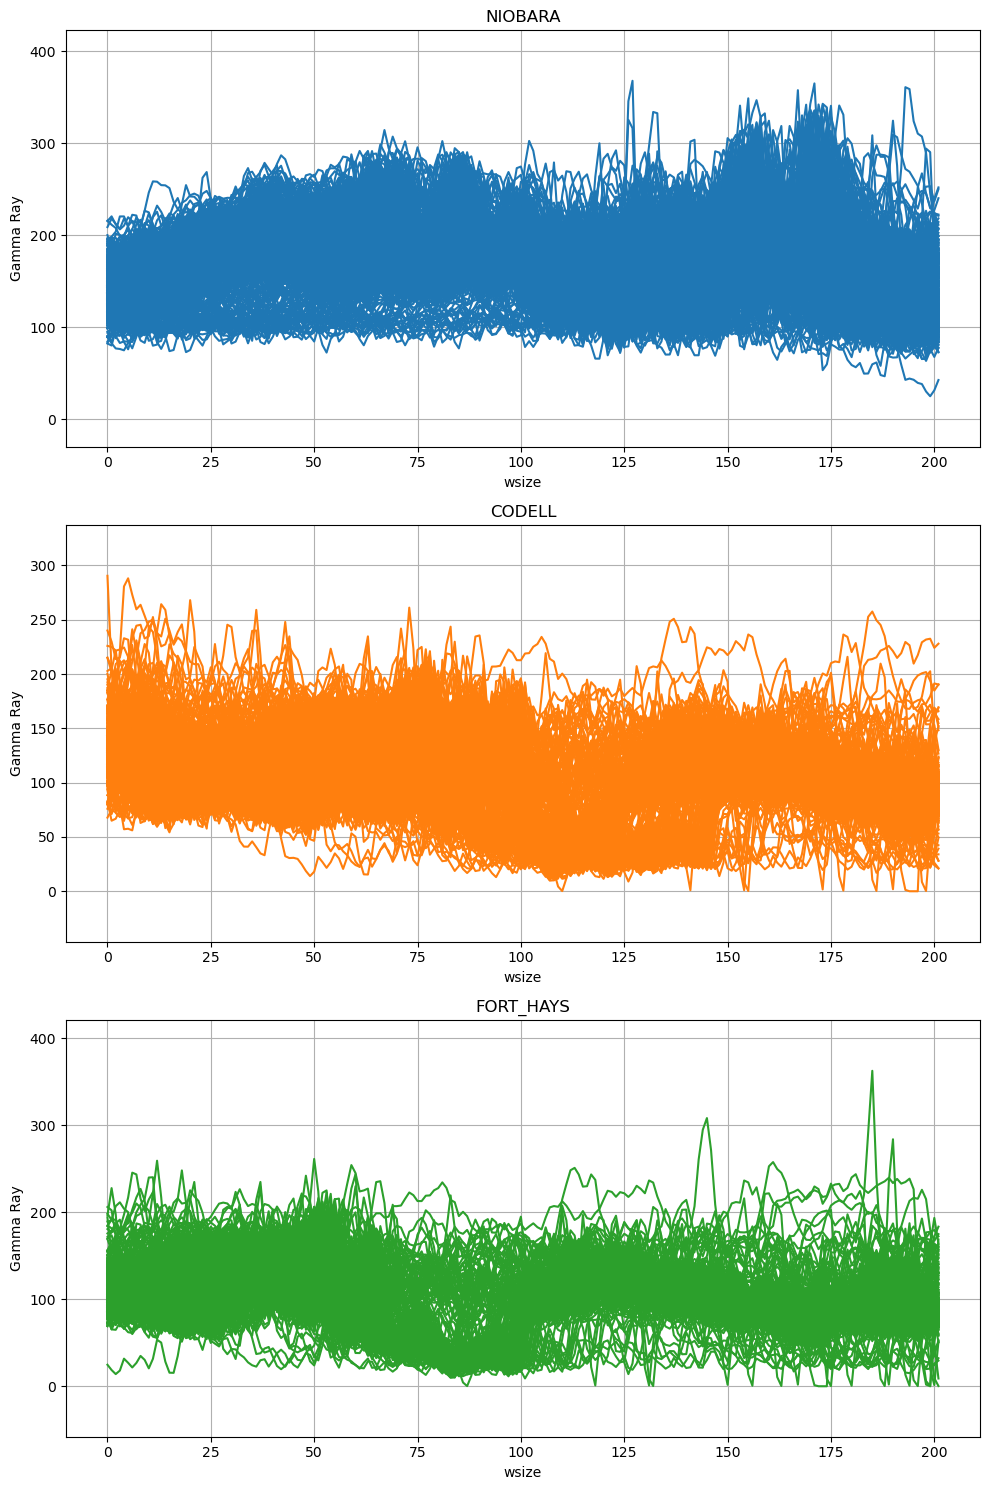

In [11]:
# Define a window size of the signature
wsize = 100
top_list = ['NIOBARA','CODELL', 'FORT_HAYS']
features_np, labels_np, well_np = plot_and_extract_pattern_local(df_log, df_tops,  top_list, wsize)

Computing distance matrix for NIOBARA...
Progress: 40 %
Progress: 80 %
Computing clusters for NIOBARA...
Cluster -1 with  297 elements
Cluster 0 with  11 elements
Cluster 1 with  18 elements
Cluster 2 with  43 elements
Cluster 3 with  161 elements
Cluster 4 with  6 elements
Computing distance matrix for CODELL...
Progress: 40 %
Progress: 80 %
Computing clusters for CODELL...
Cluster -1 with  271 elements
Cluster 0 with  13 elements
Cluster 1 with  14 elements
Cluster 2 with  199 elements
Cluster 3 with  23 elements
Cluster 4 with  6 elements
Cluster 5 with  10 elements
Computing distance matrix for FORT_HAYS...
Progress: 40 %
Progress: 80 %
Computing clusters for FORT_HAYS...
Cluster -1 with  407 elements
Cluster 0 with  7 elements
Cluster 1 with  14 elements
Cluster 2 with  13 elements
Cluster 3 with  10 elements
Cluster 4 with  49 elements
Cluster 5 with  36 elements


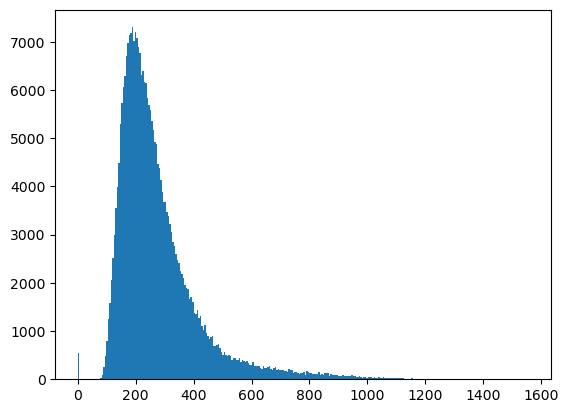

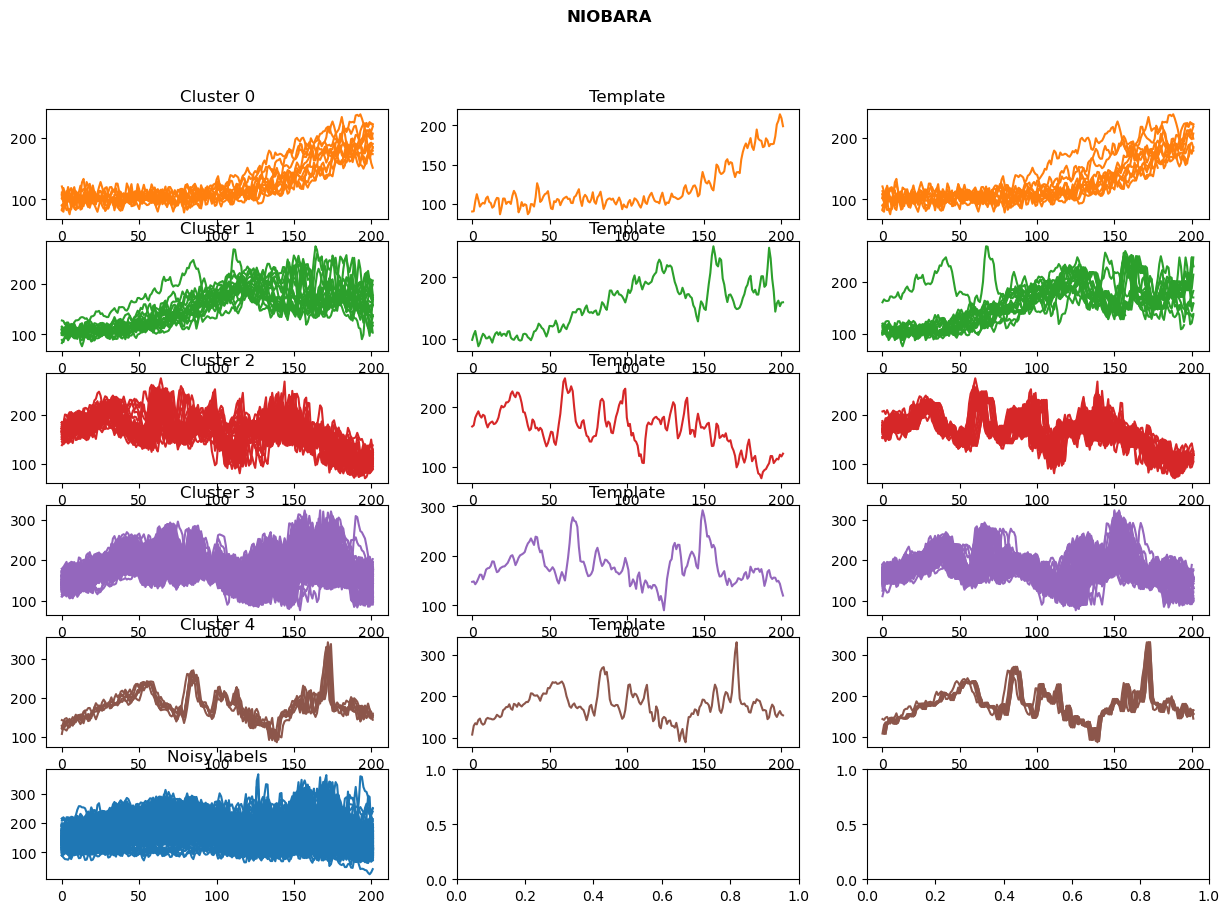

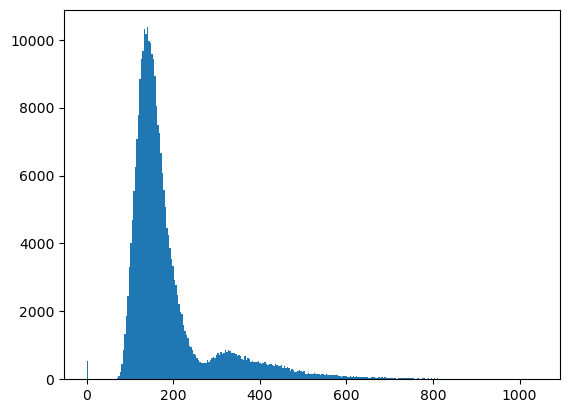

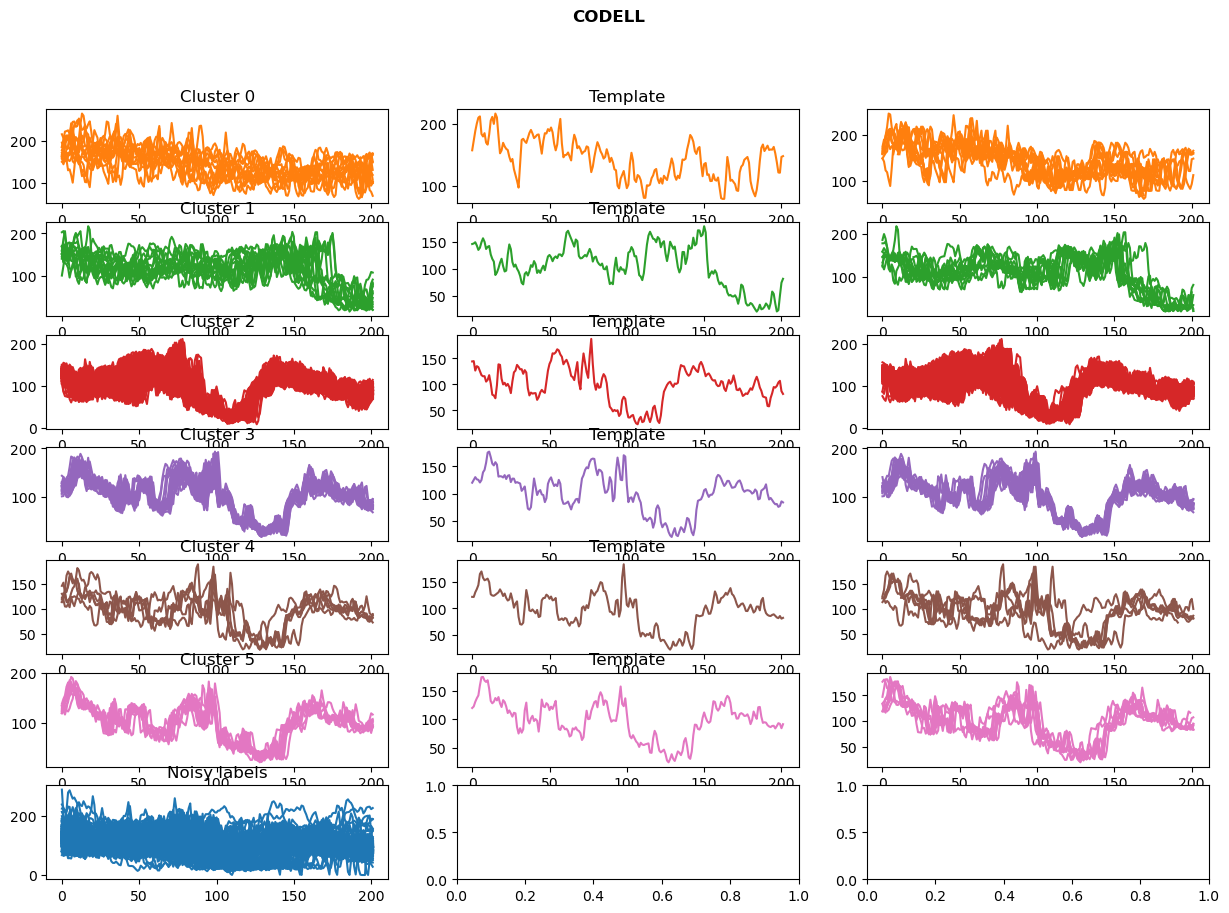

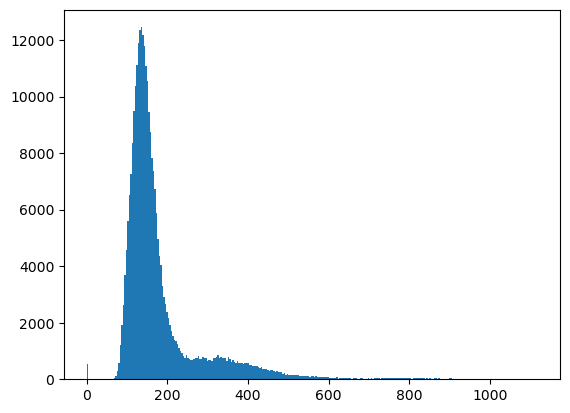

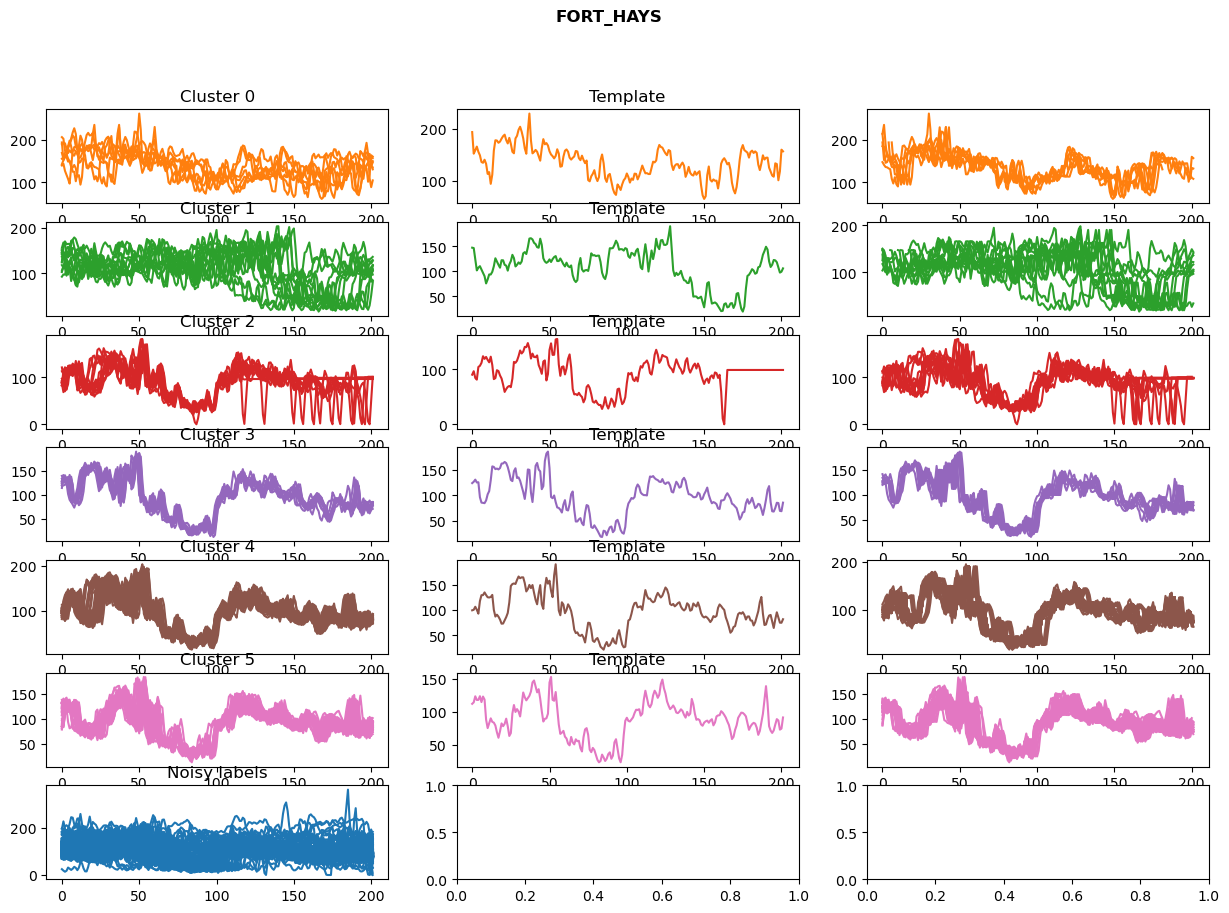

In [12]:
distance_matrix_per_top, template_list_per_top, cluster_list_per_top, cluster_well_list_per_top = cluster_dtw_distance_hdbscan(features_np, labels_np, well_np, top_list, 200)

In [13]:
template_ids_list, training_well_list = training_well(top_list, cluster_well_list_per_top, best_template=True)

NIOBARA
The clusters taken for this top are  3 2
CODELL
The clusters taken for this top are  2 3
FORT_HAYS
The clusters taken for this top are  4 5


### Testing on validation set

In [15]:
df_test_log = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/logs_50.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400
#df_test_log.head()
df_test_tops = pd.read_csv('data/well_logs_data/Colorado_data/testdata/tops_50.csv')
df_test_tops = df_test_tops.set_index('wellName')
#cols = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']
#df_test_tops = df_test_tops[cols]
df_test_tops.head()

,NIOBARA,FORT_HAYS,CODELL
wellName,,,
512330506,6283.0,6543.0,6518.0
512326146,6458.0,6729.0,6705.0
512326065,6260.0,6536.0,6504.0
512325052,6484.0,6753.0,6730.0
512322973,6518.5,6802.0,6776.0


In [16]:
def marker_selection(top_list, template_ids_list, template_list_per_top ):

    marker_signature_template = []
    for i in range(0, len(top_list)):    
        marker = top_list[i]
        print(marker)
        idx = template_ids_list[i][0]
        template = template_list_per_top[i][idx]
        marker_signature_template.append(template)

    return marker_signature_template

def marker_dwt(marker_signature_template, gr, dep_seq, wsize):
    
    pred_m = []
    for i in range(0, len(top_list)):
        #print(i)
        query =marker_signature_template[i] #the signature template for the top
        sa = subsequence_alignment(query, gr)
        match = sa.best_match()
        #print(match)
        if len(match.segment) == 2:
            startidx, endidx = match.segment
            mdep_idx = (startidx + endidx)/2
        else:
            startidx = match.segment
            mdep_idx = (startidx + wsize/2)
            
        mdep = dep_seq[int(mdep_idx)]
        pred_m.append(mdep)

    return pred_m

In [28]:
top_list = ['NIOBARA','CODELL', 'FORT_HAYS']
marker_signature_template = marker_selection(top_list, template_ids_list, template_list_per_top )

NIOBARA
CODELL
FORT_HAYS


In [29]:
wsize = 201
input_variable = ['GR']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','NIOBARA','CODELL', 'FORT_HAYS']))

for well in df_test_tops.index:
    print(well)
    df_gr = Well_grlog_cleaning(well, df_test_log, input_variable)
    dep_seq = df_gr.index
    gr = df_gr.to_numpy()
    pred_m = marker_dwt(marker_signature_template, gr, dep_seq, wsize)
    row = {'wellName':well, 'NIOBARA':pred_m[0], 'CODELL':pred_m[1], 'FORT_HAYS':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
df_tops_pred.head()

512330506
512326146
512326065
512325052
512322973
512326025
512320984
512324081
512330515
512330173
512324444
512325116
512329241
512322788
512326044
512323901
512320936
512320968
512326812
512323140
512323383
512326190
512324766
512325817
512325048
512326906
512322535
512323172
512323876
512331401
512323384
512323171
512327047
512325600
512326066
512325802
512322242
512324020
512325132
512322732
512322775
512327050
512331484
512322802
512325665
512326318
512324084
512326072
512326383
512326092


,NIOBARA,CODELL,FORT_HAYS
wellName,,,
512320936.0,6513,6767,6791
512320968.0,6532,6791,6811
512320984.0,6467,6718,6743
512322242.0,6364,6584,6609
512322535.0,6455,6624,6641


In [40]:
list(df_tops_pred.loc[[well]].values[0])

[6513, 6767, 6791]

In [30]:
tr = [20, 15, 10, 5]
for tolerance in tr:
    
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

tolerance 20, recall 0.9333333333333333, mae 7.483333333333333
tolerance 15, recall 0.8533333333333334, mae 7.483333333333333
tolerance 10, recall 0.7866666666666666, mae 7.483333333333333
tolerance 5, recall 0.6, mae 7.483333333333333


In [41]:
import matplotlib.pyplot as plt

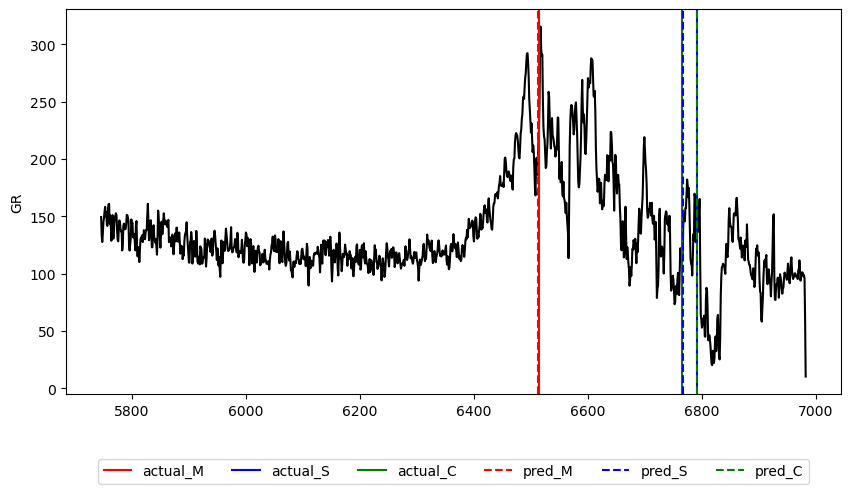

In [44]:
well = 512320936.0
td = list(df_test_tops.loc[[well]].values[0])
pred_m = list(df_tops_pred.loc[[well]].values[0])
plot_result_distribution(td, start_depth = 5000, pred_m=pred_m,  df_wm=df_gr, Industrial_baseline=True )

In [47]:
#test for another set of unlabeld wells
df_test_log_100 = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/logs_100.parquet', engine='fastparquet')
df_test_log_100.loc[df_test_log_100['GR'] < -1, 'GR' ] = -1
df_test_log_100.loc[df_test_log_100['GR'] > 400, 'GR' ] = 400
#df_loc = df_loc.reset_index()
df_test_loc_100 = pd.read_parquet('data/well_logs_data/Colorado_data/testdata/loc_100.parquet', engine='fastparquet')
df_test_loc_100 = df_test_loc_100.reset_index()
df_test_log_100 = df_test_loc_100.merge(df_test_log_100, how = 'inner', left_on = 'wellName', right_on = 'wellName')
print(df_test_log_100.head())
df_test_tops_100 = pd.read_csv('data/well_logs_data/Colorado_data/testdata/tops_100.csv')
df_test_tops_100 = df_test_tops_100.set_index('wellName')
cols = ['NIOBARA','CODELL', 'FORT_HAYS']
df_test_tops_100 = df_test_tops_100[cols]
print(df_test_tops_100.head())

    wellName   Latitude  Longitude  DEPTH       GR
0  512326026  48.756404   2.116624  477.0  76.5729
1  512326026  48.756404   2.116624  477.5  83.7471
2  512326026  48.756404   2.116624  478.0  89.9259
3  512326026  48.756404   2.116624  478.5  90.3770
4  512326026  48.756404   2.116624  479.0  89.9387
           NIOBARA  CODELL  FORT_HAYS
wellName                             
512326026   6530.0  6791.0     6818.0
512322735   6585.0  6847.5     6871.0
512326909   6240.0  6472.0     6499.0
512325828   6269.0  6505.0     6529.0
512330519   6236.0  6471.0     6494.0


In [48]:
wsize = 201
df_tops_pred_100 = pd.DataFrame(pd.DataFrame(columns = ['wellName','NIOBARA','CODELL', 'FORT_HAYS']))

for well in df_test_tops_100.index:
    print(well)
    df_gr = Well_grlog_cleaning(well, df_test_log_100, input_variable)
    dep_seq = df_gr.index
    gr = df_gr.to_numpy()
    pred_m = marker_dwt(marker_signature_template, gr, dep_seq, wsize)
    row = {'wellName':well, 'NIOBARA':pred_m[0], 'CODELL':pred_m[1], 'FORT_HAYS':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred_100 = df_tops_pred.set_index('wellName')
print(df_tops_pred_100.head())
print(df_test_tops_100.head())

512326026
512322735
512326909
512325828
512330519
512325280
512326560
512325218
512325966
512322304
512329420
512330512
512326819
512324085
512324588
512326756
512324331
512326373
512326117
512331704
512325421
512323180
512324022
512327284
512327295
512326416
512320982
512324480
512320966
512325742
512329242
512329972
512327289
512329416
512322803
512326311
512322729
512331841
512323162
512324561
512323179
512326535
512323378
512323055
512325825
512327286
512323998
512325079
512326130
512323175
512322734
512330518
512329240
512322854
512324060
512325115
512323164
512322733
512323138
512325724
512320967
512329960
512323851
512325427
512327052
512320981
512326905
512325117
512324998
512323161
512329967
512326434
512323163
512326047
512323178
512328194
512325108
512325827
512326211
512323924
512322244
512328084
512330489
512325220
512327051
512324332
512325047
512327283
512325496
512326132
512324094
512322774
512326152
512330517
512325281
512322532
512323102
512330486
512326320
512325377


In [28]:
df_tops_pred_100 = df_tops_pred_100[df_tops_pred_100.index.notnull()]

In [29]:
for tolerance in tr:
    
    recall, mae, df_res = recall_tops(df_test_tops_100, df_tops_pred_100, tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

tolerance 20, recall 0.94, mae 6.6033333333333335
tolerance 15, recall 0.89, mae 6.6033333333333335
tolerance 10, recall 0.78, mae 6.6033333333333335
tolerance 5, recall 0.6366666666666667, mae 6.6033333333333335
